In [3]:
import os
import typing

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import *
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

import sklearn.gaussian_process.kernels as ker
from sklearn import pipeline
from time import time

import sklearn.gaussian_process as gp

from sklearn import pipeline
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.kernel_approximation import (RBFSampler, Nystroem)
from sklearn.preprocessing import StandardScaler

# Set `EXTENDED_EVALUATION` to `True` in order to visualize your predictions.
EXTENDED_EVALUATION = False
EVALUATION_GRID_POINTS = 300  # Number of grid points used in extended evaluation
EVALUATION_GRID_POINTS_3D = 50  # Number of points displayed in 3D during evaluation


# Cost function constants
THRESHOLD = 35.5
COST_W_NORMAL = 1.0
COST_W_OVERPREDICT = 5.0
COST_W_THRESHOLD = 20.0


In [4]:
# load data
train_x_name = "train_x.csv"
train_y_name = "train_y.csv"

train_x = np.loadtxt(train_x_name, delimiter=',',skiprows=1)
train_y = np.loadtxt(train_y_name, delimiter=',',skiprows=1)

print("Loaded {} training data points".format(train_x.shape[0]))

# load the test dateset
test_x_name = "test_x.csv"
test_x = np.loadtxt(test_x_name, delimiter=',',skiprows=1)

Loaded 15189 training data points


3311


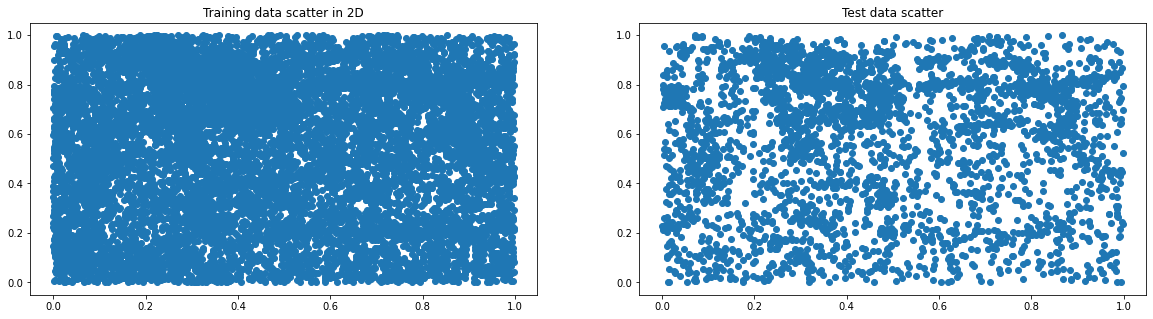

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.scatter(train_x[:,0], train_x[:,1])
ax1.set_title("Training data scatter in 2D")

ax2.scatter(test_x[:,0], test_x[:,1])
ax2.set_title("Test data scatter")
plt.show()

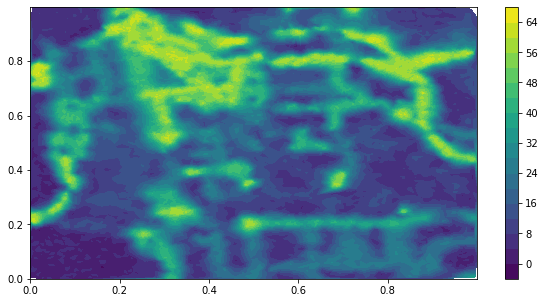

In [6]:

fig, ax = plt.subplots(figsize=(10,5))
tcf = ax.tricontourf(train_x[:,0], train_x[:,1], train_y, 20)
fig.colorbar(tcf)
plt.show()

In [7]:
def cost_function(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    """
    Calculates the cost of a set of predictions.

    :param y_true: Ground truth pollution levels as a 1d NumPy float array
    :param y_predicted: Predicted pollution levels as a 1d NumPy float array
    :return: Total cost of all predictions as a single float
    """
    assert y_true.ndim == 1 and y_predicted.ndim == 1 and y_true.shape == y_predicted.shape

    # Unweighted cost
    cost = (y_true - y_predicted) ** 2
    weights = np.zeros_like(cost)

    # Case i): overprediction
    mask_1 = y_predicted > y_true
    weights[mask_1] = COST_W_OVERPREDICT

    # Case ii): true is above threshold, prediction below
    mask_2 = (y_true >= THRESHOLD) & (y_predicted < THRESHOLD)
    weights[mask_2] = COST_W_THRESHOLD

    # Case iii): everything else
    mask_3 = ~(mask_1 | mask_2)
    weights[mask_3] = COST_W_NORMAL

    # Weigh the cost and return the average
    return np.mean(cost * weights)


In [15]:
# number of data point sampled from the dense x0 region [-1.0, -0.5]
num_samples = 500

#
dense_data = np.concatenate([train_x, train_y.reshape(-1, 1)], axis=1)
np.random.shuffle(dense_data)

# random shuffle datapoints in the dense region and select 150 to balance the data
train_x_dense_sampled = dense_data[:num_samples,:2]
train_y_dense_sampled = dense_data[:num_samples,2]

# do the train-validation split evenly in the dense and the sparse region
X_train_dense, X_val_dense, y_train_dense, y_val_dense = train_test_split(train_x_dense_sampled, train_y_dense_sampled, test_size=0.33, random_state=42)

X_train = X_train_dense
y_train = y_train_dense
X_val = X_val_dense
y_val = y_val_dense

print("Sampled X_train shape:", X_train.shape)
print("Sampled y_train shape:", y_train.shape)
print("Sampled X_val shape:", X_val.shape)
print("Sampled y_val shape:", y_val.shape)

Sampled X_train shape: (335, 2)
Sampled y_train shape: (335,)
Sampled X_val shape: (165, 2)
Sampled y_val shape: (165,)


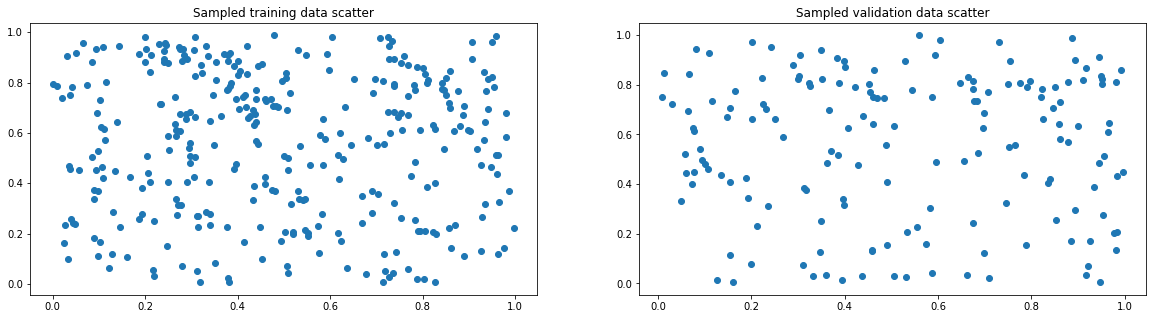

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.scatter(X_train[:,0], X_train[:,1])
ax1.set_title("Sampled training data scatter")
ax2.scatter(X_val[:,0], X_val[:,1])
ax2.set_title("Sampled validation data scatter")
plt.show()

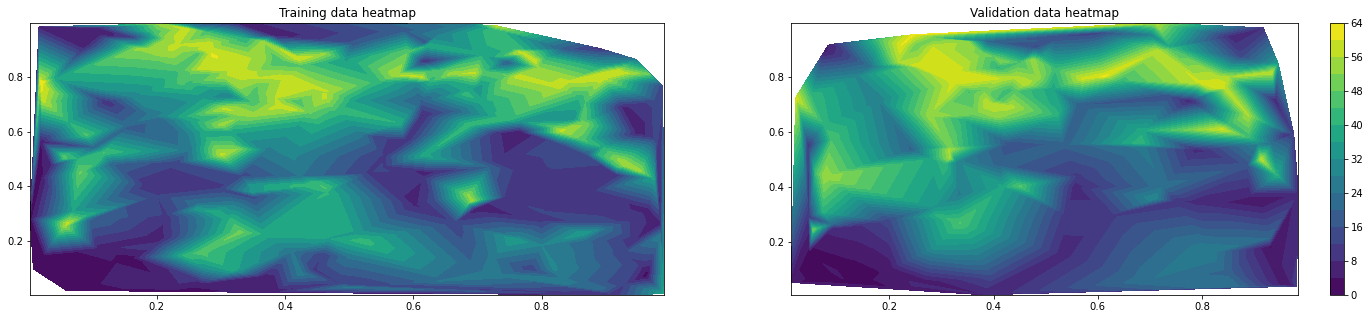

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,5))
tcf1 = ax1.tricontourf(X_train[:,0], X_train[:,1], y_train, 20)
ax1.set_title("Training data heatmap")
tcf2 = ax2.tricontourf(X_val[:,0], X_val[:,1], y_val, 20)
ax2.set_title("Validation data heatmap")

fig.colorbar(tcf1)
plt.show()

In [11]:
scaler = StandardScaler().fit(X_train)

In [33]:
k = ker.Matern() + ker.ConstantKernel()
gpr = gp.GaussianProcessRegressor(kernel=k, alpha=0.01, n_restarts_optimizer=50, random_state=42)
noisyMat_gpr = pipeline.Pipeline([
    #("scaler", scaler),
    ("gpr", gpr)
])

print("Fitting noisy Matern kernel GPR")
start = time()
noisyMat_gpr.fit(X_train, y_train)
y_val_hat, std = noisyMat_gpr.predict(X_val, return_std=True)
score = cost_function(y_val, y_val_hat)
print("Took {} seconds, score = {}".format(time() - start, score))

Fitting noisy Matern kernel GPR
Took 70.11076593399048 seconds, score = 315.6041630632129


In [26]:
k = ker.Matern(length_scale=0.1, nu=1.5) + \
    ker.WhiteKernel(noise_level=1e-9);

param_grid = {
    "alpha": [0.001,0.01, 0.1,1],
    "n_restarts_optimizer": [1,5,15,25],
    "random_state": [5, 15, 35],
    "kernel":[k]
}


gpr = gp.GaussianProcessRegressor()
grid_search = GridSearchCV(gpr, param_grid, cv=5,
                          scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianProcessRegressor(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1],
                         'kernel': [Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=1e-09)],
                         'n_restarts_optimizer': [1, 5, 15, 25],
                         'random_state': [5, 15, 35]},
             scoring='neg_mean_squared_error')

In [27]:
grid_search.best_params_

{'alpha': 0.1,
 'kernel': Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=1e-09),
 'n_restarts_optimizer': 1,
 'random_state': 15}

Noisy mattern kernel
Took 237.53357219696045 seconds, score = 175.1111252678883
Best score: 175.1111252678883

In [28]:
grid_search.best_estimator_

GaussianProcessRegressor(alpha=0.1,
                         kernel=Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=1e-09),
                         n_restarts_optimizer=1, random_state=15)

In [31]:
grid = {
    "length_scale": [0.1],
    "nu": [1.5],
    "kernel_noise": [1e-9],
    "safety_increase": [5]
}

gpr = gp.GaussianProcessRegressor(kernel=None, alpha=0.1, n_restarts_optimizer=1, random_state=15, normalize_y=True)

noisyMat_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("gpr", gpr)
])

matern_scores = []
params_list = ParameterGrid(grid)
for params in params_list:
    k = ker.Matern(length_scale=params['length_scale'], nu=params['nu']) + \
        ker.WhiteKernel(noise_level=params['kernel_noise'])
    noisyMat_gpr.set_params(**{
      "gpr__kernel": k,
    })

    print("Fitting noisy Matern GPR for", params)
    start = time()
    noisyMat_gpr.fit(X_train, y_train)
    
    y_val_hat = noisyMat_gpr.predict(X_val)
    # we add a safety increase to 'safe' predictions since false negatives are penalized harshly
    predict_safe = (y_val_hat < THRESHOLD).astype(int)
    y_val_hat += params['safety_increase'] * predict_safe
    score = cost_function(y_val, y_val_hat)
    matern_scores.append(score)

    print("Took {} seconds, score = {}".format(time() - start, score))

matern_scores_min = min(matern_scores)
best_params = params_list[matern_scores.index(matern_scores_min)]

print("Best score: {}\nParams: {}".format(matern_scores_min, best_params))

Fitting noisy Matern GPR for {'kernel_noise': 1e-09, 'length_scale': 0.1, 'nu': 1.5, 'safety_increase': 5}
Took 0.3756856918334961 seconds, score = 565.9596838819214
Best score: 565.9596838819214
Params: {'safety_increase': 5, 'nu': 1.5, 'length_scale': 0.1, 'kernel_noise': 1e-09}


In [12]:
param_grid = [
    {'n_estimators':[3,10,30],
    'alpha':[1e-10,1e-7,1e-5,1e-3,1e-2]
    }
]

def my_custom_time
gpr = gp.GaussianProcessRegressor()
grid_search = GridSearchCV(gpr,param_grid)

In [ ]:
grid = {
    "rbf": [0.0, 1.0, 2.0],
    "matern": [0.0, 1.0, 2.0],
    "rq": [0.0, 1.0, 2.0],
    "white": [0.0, 1.0, 2.0]    
}

gpr = gp.GaussianProcessRegressor(kernel=None, n_restarts_optimizer=5, random_state=42, normalize_y=True)
sumKernel_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("gpr", gpr)
])

sumKernel_scores = []
params_list = ParameterGrid(grid)
for params in params_list:
    k = params['rbf'] * ker.RBF() + params['matern'] * ker.Matern() + params['rq'] * ker.RationalQuadratic() + params['white'] * ker.WhiteKernel()
    sumKernel_gpr.set_params(**{
      "gpr__kernel": k,
    })

    print("Fitting sum kernel GPR for", params)
    start = time()
    sumKernel_gpr.fit(X_train, y_train)
    y_val_hat = sumKernel_gpr.predict(X_val)
    predict_safe = (y_val_hat < THRESHOLD).astype(int)
    y_val_hat += 5 * predict_safe
    score = cost_function(y_val, y_val_hat)
    print("Took {} seconds, score = {}".format(time() - start, score))
    sumKernel_scores.append(score)

sumKernel_scores_min = min(sumKernel_scores)
best_params = params_list[sumKernel_scores.index(sumKernel_scores_min)]

print("Best score: {}\nParams: {}".format(matern_scores_min, best_params))

Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 0.0, 'rq': 0.0, 'white': 0.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 9.561373949050903 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 0.0, 'rq': 0.0, 'white': 1.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 9.692620992660522 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 0.0, 'rq': 0.0, 'white': 2.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 8.733903408050537 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 0.0, 'rq': 1.0, 'white': 0.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 11.274445295333862 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 0.0, 'rq': 1.0, 'white': 1.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 9.224339008331299 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 0.0, 'rq': 1.0, 'white': 2.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 10.189192056655884 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 0.0, 'rq': 2.0, 'white': 0.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 11.553120613098145 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 0.0, 'rq': 2.0, 'white': 1.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 8.731240034103394 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 0.0, 'rq': 2.0, 'white': 2.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 9.21700644493103 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 1.0, 'rq': 0.0, 'white': 0.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 9.769046545028687 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 1.0, 'rq': 0.0, 'white': 1.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 8.585200071334839 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 1.0, 'rq': 0.0, 'white': 2.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 8.619526147842407 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 1.0, 'rq': 1.0, 'white': 0.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 13.585491180419922 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 1.0, 'rq': 1.0, 'white': 1.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 13.207972526550293 seconds, score = 491.8055493823743
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 1.0, 'rq': 1.0, 'white': 2.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 11.948360919952393 seconds, score = 491.8250547278456
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 1.0, 'rq': 2.0, 'white': 0.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 10.831994771957397 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 1.0, 'rq': 2.0, 'white': 1.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 10.354779958724976 seconds, score = 491.82476574648456
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 1.0, 'rq': 2.0, 'white': 2.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 9.644612550735474 seconds, score = 491.81884860624683
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 2.0, 'rq': 0.0, 'white': 0.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 9.304073333740234 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 2.0, 'rq': 0.0, 'white': 1.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Took 9.51133918762207 seconds, score = 478.10880457410497
Fitting sum kernel GPR for {'matern': 0.0, 'rbf': 2.0, 'rq': 0.0, 'white': 2.0}


/home/loverebecca/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


In [ ]:
grid = {
    "length_scale": [0.01, 0.05, 0.1, 0.5],
    "kernel_noise": [1e-5, 1e-3],
    "alpha": [0.1, 0.5, 1.0, 3.0],
    "safety_increase": [0.1, 0.2]
}

gpr = gp.GaussianProcessRegressor(kernel=None, alpha=0.01, n_restarts_optimizer=5, random_state=42, normalize_y=True)
noisyMatRQ_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("gpr", gpr)
])

maternRQ_scores = []
params_list = ParameterGrid(grid)
for params in params_list:
    k = ker.Matern(length_scale=0.01, nu=2.5) + \
        ker.RationalQuadratic(length_scale=params['length_scale'], alpha=params['alpha']) + \
        ker.WhiteKernel(noise_level=params['kernel_noise'])
    noisyMatRQ_gpr.set_params(**{
      "gpr__kernel": k,
    })

    print("Fitting noisy additive Matern RQ GPR for", params)
    start = time()
    noisyMatRQ_gpr.fit(X_train, y_train)
    
    y_val_hat = noisyMatRQ_gpr.predict(X_val)
    # we add a safety increase to 'safe' predictions since false negatives are penalized harshly
    predict_safe = (y_val_hat < THRESHOLD).astype(int)
    y_val_hat += params['safety_increase'] * predict_safe
    score = cost_function(y_val, y_val_hat)
    maternRQ_scores.append(score)

    print("Took {} seconds, score = {}".format(time() - start, score))

maternRQ_scores_min = min(maternRQ_scores)
best_params = params_list[maternRQ_scores.index(maternRQ_scores_min)]

print("Best score: {}\nParams: {}".format(maternRQ_scores_min, best_params))

In [ ]:
grid = {
    "length_scale": [0.01, 0.05, 0.1, 0.2, 0.5],
    "kernel_noise": [1e-5, 1e-3],
    "safety_increase": [0.1, 0.15, 0.2]
}

gpr = gp.GaussianProcessRegressor(kernel=None, alpha=0.01, n_restarts_optimizer=10, random_state=42, normalize_y=True)
noisyMatRBF_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("gpr", gpr)
])

maternRBF_scores = []
params_list = ParameterGrid(grid)
for params in params_list:
    k = ker.Matern(length_scale=0.01, nu=2.5) + \
        ker.RBF(length_scale=params['length_scale']) + \
        ker.WhiteKernel(noise_level=params['kernel_noise'])
    noisyMatRBF_gpr.set_params(**{
      "gpr__kernel": k,
    })

    print("Fitting noisy additive Matern RBF GPR for", params)
    start = time()
    noisyMatRBF_gpr.fit(X_train, y_train)
    
    y_val_hat = noisyMatRBF_gpr.predict(X_val)
    # we add a safety increase to 'safe' predictions since false negatives are penalized harshly
    predict_safe = (y_val_hat < THRESHOLD).astype(int)
    y_val_hat += params['safety_increase'] * predict_safe
    score = cost_function(y_val, y_val_hat)
    maternRBF_scores.append(score)

    print("Took {} seconds, score = {}".format(time() - start, score))

maternRBF_scores_min = min(maternRBF_scores)
best_params = params_list[maternRBF_scores.index(maternRBF_scores_min)]

print("Best score: {}\nParams: {}".format(maternRBF_scores_min, best_params))